In [6]:
import numpy as np
import numpy.random as random
import matplotlib.pyplot as plt
%matplotlib inline
from game import game, random_connection_game

In [7]:
import time
from IPython.display import clear_output

In [70]:
def randomAgent(state, Memb = 25):
    #move = random.randint(3)
    spin_1 = random.randint(Memb)
    spin_2 = random.randint(4)
    return (spin_1, spin_2)

In [108]:
import numpy as np
import numpy.random as random
import matplotlib.pyplot as plt
def square_lattice(i,j, Lx = None, Ly = None): 
    ''' Square lattice with close boundary conditions
    '''
    neighbours = []
    if i+1<Lx:
        neighbours.append([i+1,j])
    if i-1> -1:
        neighbours.append([i-1,j])
    if j+1<Ly:
        neighbours.append([i,j+1])
    if j-1> -1:
        neighbours.append([i,j-1])
        
    return neighbours
    
class game:
    def __init__(self, H, Memb = None, Ls = None, lattice = square_lattice,
                                    max_consecutive_failures = 20):
        '''
        Three possible moves:   1. add new spin
                                2. copy a spin
                                3. add interaction
        
        Input:
         - H: initial hamiltonian that will be translated to architecture 
         - Memb: Number of sites where embedded hamiltonian is defined
         - Ls: tuple with linear sizes if Memb is not a perfect root
         - lattice: function that for site i,j gives a list of neighbours, e.g.
                     [[i+1,j],[i-1,j],[i,j+1],[i+1,j-1]]
                     (default: square lattice with closed boundary conditions)
         - max_consecutive_failures: maximum number of consecutive 
                             failed moves that the game is allowed before it
                             is lost.
         
        Methods implemented:
         ....
        '''
        # Copy of the original hamiltonian 
        self.H = np.array(H)
        # Copy of the hamiltonian that will be used for the game
        # self.Hmask = np.array(H)

        # number of spins
        self.nS = H.shape[0]
        
        if Memb is None:
            self.Hemb = H*0.0
            self.Memb = self.nS
        else:
            self.Hemb = np.zeros((Memb, Memb))
            # Copy of the hamiltonian that will be used for the game
            self.Hmask = np.zeros((Memb, Memb))
            self.Hmask[:self.nS,:self.nS] = 1*(np.abs(self.H)>0)
            self.Memb = Memb
        
        # whether it has been used or not        
        self.usedS = np.zeros(self.nS)
        # array of unique spins
        self.uniqS = np.zeros(self.Memb, dtype=int)-1
        # position of spin 
        self.posS = np.zeros(self.Memb, dtype = int) 
        
        # Linear sizes
        if Ls is None:
            L = np.int(np.sqrt(self.Memb))
            self.Lx, self.Ly = L, L
        else:
            self.Lx, self,Ly = Ls[0], Ls[1]
        
        # Number of spins and unique spins
        self.N = 0
        self.N0 = 0
        # lattice function
        self.lattice = lattice
        self.n_neighbours = 4
        
        # State: turn of copying or adding a new one
        self.copyadd = 1
        self.empty_sites = self.Memb
        self.terms_left = (self.Hmask>0).sum()
        self.finished = 0
        self.score = 0
        self.reward = 0
        self.state = self.get_state()
        self.number_nomoves = 0
        self.max_confailures = max_consecutive_failures 
        
    def get_state(self, linear = False):
        if linear:
            return np.concatenate((self.Hemb.ravel(),
                               self.Hmask[:self.nS,:self.nS].ravel()))
        else:
            return np.concatenate((np.expand_dims(self.Hemb,0),
                    (0.8+0.4*random.rand())*np.expand_dims(self.Hmask,0)))
            
    def reset(self):
        self.Hemb = np.zeros((self.Memb, self.Memb))
        self.Hmask = np.zeros((self.Memb, self.Memb))
        self.Hmask[:self.nS,:self.nS] = 1*(np.abs(self.H)>0)
        
        # whether it has been used or not        
        self.usedS = np.zeros(self.nS)
        # array of unique spins
        self.uniqS = np.zeros(self.Memb, dtype=int)-1
        # indices of original spin that it might be copy of
        self.posS = np.zeros(self.Memb, dtype = int) 
        # Number of spins and unique spins
        self.N = 0
        self.N0 = 0
        
        # State: turn of copying or adding a new one
        self.copyadd = 1
        self.empty_sites = self.Memb
        self.terms_left = (self.Hmask>0).sum()
        self.finished = 0
        self.score = 0
        self.reward = 0
        self.state = self.get_state()
        self.number_nomoves = 0
        return self.state
    
    def __len__(self):
        return self.N
    
    
    def add_new_spin(self, i):
        '''
          - i: index of new spin or row in hamiltonian
          
        '''
        if self.uniqS[i]==-1 and self.N0<self.nS:
            self.uniqS[i] = self.N0
            self.posS[self.N] = i
            #self.usedS[i] = 1


            # Interacting terms that we use
            h0 = self.H[self.N0, self.N0]*1.0
            self.Hmask[self.N0, self.N0] = 0.0
            
            self.Hemb[i,i] = h0

            self.N += 1
            self.N0 += 1
            self.empty_sites -= 1
            self.terms_left -= 1
            self.update_score(0)
            self.number_nomoves = 0
        else:
            self.number_nomoves += 1
            
            self.update_score(-1)
            #It's already occupied
    
    def copy_spin(self, i, j, fer_int = 1.0):
        if self.uniqS[i] != self.uniqS[j] and self.uniqS[j] == -1:
            self.uniqS[j] = self.uniqS[i]
            self.posS[self.N] = i
            
            self.Hemb[i,j] = fer_int
            self.Hemb[j,i] = fer_int
            # self.Hemb[j,j] = self.Hemb[i,i]*1.0

            self.N += 1
            self.empty_sites -= 1
            self.update_score(1)

            self.number_nomoves = 0
        else:
            
            self.update_score(-1)
            self.number_nomoves += 1
            
    def add_interaction(self, i, j, jint = None):
        '''
          - i, j: indices of (neighbouring) sites to connect
        '''
        
        i0 = self.uniqS[i] 
        j0 = self.uniqS[j]
        
        if i0> -1 and j0> -1:
            jint0 = self.Hmask[i0,j0]
            
            # If there is no interaction test the other neighbours
            if jint0<=0.0:
                js = [self.get_neighbours(i, j1) for j1 in range(4)]
                js = [ji for ji in js if ji > -1]
                for j in js:
                    j0 = self.uniqS[j]
                    jint0 = self.Hmask[i0,j0]
                    if jint0>0.0:
                        break
                        
            jint = self.H[i0,j0]
            if jint0>0.0:
                #print(jint,i0,j0)
                self.Hemb[i,j] = jint
                self.Hemb[j,i] = jint

                self.Hmask[i0,j0] = 0.0
                self.Hmask[j0,i0] = 0.0

                self.terms_left -= 2
                self.update_score(2)
                self.number_nomoves = 0
            else:
                self.update_score(-1)
                # At least one of them does not exists
                self.number_nomoves += 1
        else:
            self.update_score(-1)
            # At least one of them does not exists
            self.number_nomoves += 1
            
        
        
    def update_score(self, i):
        if i == 0:
            # Added new spin
            #self.reward += 0.5
            pass
        elif i == 1:
            # Copied spin
            self.reward -= 0.5
        elif i == 2:
            # Added interaction
            self.reward += 0.2
            #pass

        self.reward -= 0.2
        #if self.N>self.nS:
        #    self.score -= 0.5

    def step(self, move):
        self.reward = 0.0
        
        if self.N0<self.nS:
            self.add_new_spin(move[0])
        else:    
            spinpos_1 = self.posS[move[0]%self.N] 
            j = self.get_neighbours(spinpos_1, move[1])
            js = np.array([self.get_neighbours(spinpos_1, (move[1]+k)%4) 
                          for k in range(4)])
            
            sel = (js > -1)
            if sel.sum()>0:
                js = js[sel]
                idcs = np.arange(js.shape[0])
                i = spinpos_1
                print(i, js,':', i%self.Lx, i//self.Lx)
                for idx in idcs:
                    j = js[idx]
                    i0 = self.uniqS[i] 
                    j0 = self.uniqS[j]
                    print(i0, j0, j)
                    if i0 != j0 and j0 == -1:
                        self.copy_spin(i,j)
                        print('Copied?')
                        break
                    else:
                        jint0 = self.Hmask[i0,j0]
                        if jint0>0.0:
                            self.add_interaction(i,j)
                            
                            print('Added?')
                            break
                        else:
                            pass

            else:
                self.number_nomoves += 1

                self.update_score(-1)

        self.state = self.get_state()

        if (self.Hmask>0).sum()==0:
            self.reward += self.nS
            self.score += self.reward
            self.finished = 1 # Won
        elif self.N == self.Memb:
            self.reward -= self.nS
            self.score += self.reward
            self.finished = 1 # Lost
        if self.number_nomoves > self.max_confailures:
            self.reward -= self.nS
            self.score += self.reward
            self.finished = 1
        
        return self.state, self.reward, self.finished
        
    def oldstep(self, move):
        self.reward = 0.0
        if move[0] == 0: # Add spin
            self.add_new_spin(move[1])
        else: # Copy spin
            if self.N>0:
                #print(move[1]%self.N, self.posS)
                spinpos_1 = self.posS[move[1]%self.N]
                j = self.get_neighbours(spinpos_1, move[2])
                if j> -1:
                    if self.uniqS[j] == -1:
                        self.copy_spin(spinpos_1,j)
                    else:
                        self.add_interaction(spinpos_1,j)
                else:
                    self.number_nomoves += 1
                    
                    self.update_score(-1)
        
        self.state = self.get_state()

        if (self.Hmask>0).sum()==0:
            self.reward += self.nS
            self.score += self.reward
            self.finished = 1 # Won
        elif self.N == self.Memb:
            self.reward -= self.nS
            self.score += self.reward
            self.finished = 1 # Lost
        if self.number_nomoves > self.max_confailures:
            self.reward -= self.nS
            self.score += self.reward
            self.finished = 1
        
        return self.state, self.reward, self.finished
    
    def get_neighbours(self, i, j):
        ix, iy = i%self.Lx, i//self.Lx
        try:
            ixn, iyn =  self.lattice(ix, iy, self.Lx, self.Ly)[j]
            ipos = ixn+iyn*self.Lx
        except:
            ipos = -1
        return ipos
    
    def print(self):
        for i in range(self.Hemb.shape[0]):
            stre = self.Memb*'{:.2f} '
            print(stre.format(*self.Hemb[i,:]))
    
    def print_original(self):
        for i in range(self.H.shape[0]):
            stre = self.nS*'{:.2f} '
            print(stre.format(*self.H[i,:]))
                    
    def plot(self, fig = None, ax = None, **kwargs):
        if ax is None or fig is None:
            fig, ax = plt.subplots(1,1,**kwargs)
        
        idc0 = np.arange(self.Memb)
        idcs = idc0[self.uniqS > -1]
        ix, iy = idcs%self.Lx, idcs//self.Lx
        
        
        #print(idcs)
        xx = []
        yy = []
        uu = []
        vv = []
        cc = []
        if len(idcs)>2:
            for i0, i in enumerate(idcs):
                ix0, iy0 = i%self.Lx, i//self.Lx
                idc1 = idc0[np.abs(self.Hemb[i,:])>0]
                sel = idc1!= i 
                if len(idc1[sel])>0:
                    idc1 = idc1[sel]
                    ix1, iy1 = idc1%self.Lx, idc1//self.Lx
                    
                    xx.extend(ix0+ix1*0)
                    yy.extend(iy0+iy1*0) 
                    uu.extend(ix1-ix0) 
                    vv.extend(iy1-iy0)
                    cc.extend(self.Hemb[i,idc1])
            xx = np.array(xx)
            yy = np.array(yy)
            uu = np.array(uu)
            vv = np.array(vv)
            cc = np.array(cc)
        sel = np.abs(cc)<1
        if sel.sum()>0:
            ax.quiver(xx[sel],yy[sel],uu[sel],vv[sel],cc[sel],
               scale = self.Lx, headwidth = 0, cmap='seismic' )
        sel = ~(np.abs(cc)<1)
        #print(sel.sum())
        if sel.sum()>0:
            ax.quiver(xx[sel],yy[sel],uu[sel],vv[sel], color = 'black',
              scale = self.Lx, headwidth = 0, linewidths = 3.5, edgecolors='k')
            ax.quiver(xx[sel],yy[sel],uu[sel],vv[sel], color = 'white',
              scale = self.Lx, headwidth = 0, linewidths = 0.5,  edgecolors='white')
         
        ax.scatter(ix,iy)

        #ax.quiver
        ax.set_aspect('equal')
        #ax.set_clim(-1,1)

        ax.set_xlim(-0.05,self.Lx+0.05)
        ax.set_ylim(-0.05,self.Ly+0.05)
        return fig, ax

class random_connection_game(game):
    def __init__(self,nS, Memb = 400, p = 0.2, **kwargs):
        '''
           - p :
        '''
        self.nS0 = nS
        self.nS = nS
        self.Memb = Memb
        self.p = p
        self.H = self.generate_newH()
        
        super().__init__(self.H,Memb,**kwargs)
        
    def generate_newH(self, maxval = 0.1):
        H = np.random.randn(self.nS,self.nS)
        H = maxval*(H +H.transpose())/2.0
        sel = np.abs(H)<self.p*maxval
        H[sel] = 0.0
        self.H = H
        return H
    
    def reset(self):
        self.nS = np.random.randint(4,self.nS0+1)
        self.H = self.generate_newH()
        self.Hemb = np.zeros((self.Memb, self.Memb))
        self.Hmask = np.zeros((self.Memb, self.Memb))
        #print(self.Hmask.shape, self.H.shape, self.nS)
        self.Hmask[:self.nS,:self.nS] = 1*(np.abs(self.H)>0)
        
        # whether it has been used or not        
        self.usedS = np.zeros(self.nS)
        # array of unique spins
        self.uniqS = np.zeros(self.Memb, dtype=int)-1
        # indices of original spin that it might be copy of
        self.posS = np.zeros(self.Memb, dtype = int) 
        # Number of spins and unique spins
        self.N = 0
        self.N0 = 0
        
        # State: turn of copying or adding a new one
        self.copyadd = 1
        self.empty_sites = self.Memb
        self.terms_left = (self.Hmask>0).sum()
        self.finished = 0
        self.score = 0
        self.reward = 0
        self.state = self.get_state()
        self.number_nomoves = 0
        return self.state

In [109]:
Memb = 4*4

env = random_connection_game(4,  Memb, 
                             max_consecutive_failures = 50)

In [110]:
state = env.reset()
print(env.H.shape, env.Hemb.shape, env.Hmask.shape,
      env.state.shape)

(4, 4) (16, 16) (16, 16) (2, 16, 16)


7 [11  3  6] : 3 1
0 0 11
0 0 3
0 0 6
(5, 1)


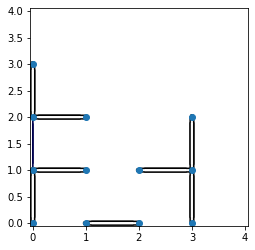

In [153]:
action = (0, 4, 0) # randomAgent(state, Memb)
state, reward, done =env.step(action)
score += reward

fig, ax = env.plot()
print(action)

In [112]:
action

(7, 1)

In [69]:
action

(0, 7, 3)

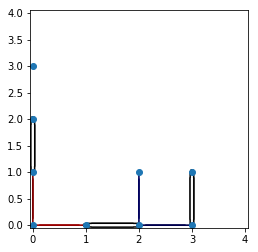

-0.4999999999999996 9 6 6 (0, 9, 1) 18


In [37]:
# Reset!
Memb = 16

env = random_connection_game(9,  Memb, 
                             max_consecutive_failures = 50)

state = env.reset()
fig, ax = env.plot()
score = 0.0
actions = []
for j in range(20):
    clear_output(wait=True)

    action = randomAgent(state, Memb)
    state, reward, done =env.step(action)
    score += reward
    actions.append((*action, reward))

    fig, ax = env.plot()
    plt.show()
    print(score, env.N, env.N0,env.nS,action, env.terms_left)
    if done >0:
        break